# Data collection

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
!python --version

Python 3.9.7


In [3]:
# get data
df = pd.read_csv('data/public_train.csv').append(pd.read_excel('data/warmup_training_dataset.xlsx'))
print(df.shape)
df.head()

(5172, 8)


,id,user_name,post_message,timestamp_post,num_like_post,num_comment_post,num_share_post,label
0,1.0,389c669730cb6c54314a46be785cea42,"THĂNG CẤP BẬC HÀM ĐỐI VỚI 2 CÁN BỘ, CHIẾN SỸ H...",1585945439,19477,378,173.0,0.0
1,2.0,775baa6d037b6d359b229a656eaeaf08,<URL>,1588939166.0,11,5,3,0.0
2,3.0,b9f3394d2aff86d85974f5040c401f08,TƯ VẤN MÙA THI: Cách nộp hồ sơ để trúng tuyển ...,1591405213,48,5,19.0,0.0
3,4.0,808e278b22ec6b96f2faf7447d10cd8e,Cơ quan Cạnh tranh và Thị trường Anh quyết địn...,1592023613,3,0,0.0,0.0
4,5.0,f81bdd6d8be4c5f64bb664214e47aced,Thêm 7 ca tại Quảng Nam liên quan đến hành khá...,1583737358,775,0,54.0,0.0


In [4]:
label_count = df.value_counts('label')
label_count

label
0.0    4238
1.0     934
dtype: int64

In [5]:
# check null value in data
df.isnull().sum()

id                    0
user_name             0
post_message          1
timestamp_post      164
num_like_post       146
num_comment_post     14
num_share_post      929
label                 0
dtype: int64

In [6]:
# check duplicate data
df[df.duplicated('post_message')]

,id,user_name,post_message,timestamp_post,num_like_post,num_comment_post,num_share_post,label
150,151.0,dd35242704071b7ddf90a8ee90055ec4,<URL>,1588947622.0,87,4,1,0.0
175,176.0,79c2d500763b7f14f2631a8ab6a71ea4,<URL>,1588917759.0,NaN,0,NaN,0.0
178,179.0,59fb67d9b2bd2b380529562035b3bab4,<URL>,1587632107.0,3,2,NaN,0.0
197,198.0,ae7c1d8434b0629a83958eac387e7424,Cơ hội có 1-0-2 để cùng nhau xây dựng những cô...,1584262049,2898,50,142.0,0.0
454,455.0,654d291ef3011072e7980e89293fbdac,<URL>,1592663724.0,4,0,NaN,0.0
...,...,...,...,...,...,...,...,...
769,769.0,297491051505678016.0,"“Giữa đại dịch virus corona, Thủ tướng Nhật Ab...",1589347145.0,126.0,7.0,17.0,0.0
776,776.0,896764849329199104.0,Bí thư Vương Đình Huệ cho biết Hà Nội đặt mục ...,1588689342.0,5.0,0.0,2.0,0.0
784,784.0,-6167405391948957696.0,TAND Cấp cao tại TP HCM đã kháng nghị Giám đốc...,1591367541.0,49.0,3.0,10.0,0.0
788,788.0,3380755255845678080.0,"Hướng về Hà Nội ❤\n\nSáng nay 7-3, Ban Chỉ đạo...",1583553093.0,30.0,4.0,6.0,0.0


In [7]:
# convert unknown record to 0 value
df.iloc[:, 4:7] = df.iloc[:, 4:7].replace('unknown', 0)

# cast from Dtype object to int64 
for i in range(3, 7):
  df.iloc[:, i] = pd.to_numeric(df.iloc[:, i], errors='coerce', downcast='integer')
  
# convert timestamp to date format
df['timestamp_post'] = pd.to_datetime(df['timestamp_post'], unit='s', errors='coerce')

In [8]:
# remove null, duplicate text content record
df = df.dropna(subset=['post_message'])
df['timestamp_post'] = df['timestamp_post'].fillna(pd.Timestamp(0)) # empty timestamp
df = df.fillna(0)
df = df.drop_duplicates(subset='post_message', keep='first')

# convert dtype of num_like, comment, share feature to int64
df.iloc[:, 4:8] = df.iloc[:, 4:8].astype('int64')

In [9]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4868 entries, 0 to 799
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                4868 non-null   float64       
 1   user_name         4868 non-null   object        
 2   post_message      4868 non-null   object        
 3   timestamp_post    4868 non-null   datetime64[ns]
 4   num_like_post     4868 non-null   int64         
 5   num_comment_post  4868 non-null   int64         
 6   num_share_post    4868 non-null   int64         
 7   label             4868 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 342.3+ KB
None


,id,user_name,post_message,timestamp_post,num_like_post,num_comment_post,num_share_post,label
0,1.0,389c669730cb6c54314a46be785cea42,"THĂNG CẤP BẬC HÀM ĐỐI VỚI 2 CÁN BỘ, CHIẾN SỸ H...",2020-04-03 20:23:59,19477,378,173,0
1,2.0,775baa6d037b6d359b229a656eaeaf08,<URL>,2020-05-08 11:59:26,11,5,3,0
2,3.0,b9f3394d2aff86d85974f5040c401f08,TƯ VẤN MÙA THI: Cách nộp hồ sơ để trúng tuyển ...,2020-06-06 01:00:13,48,5,19,0
3,4.0,808e278b22ec6b96f2faf7447d10cd8e,Cơ quan Cạnh tranh và Thị trường Anh quyết địn...,2020-06-13 04:46:53,3,0,0,0
4,5.0,f81bdd6d8be4c5f64bb664214e47aced,Thêm 7 ca tại Quảng Nam liên quan đến hành khá...,2020-03-09 07:02:38,775,0,54,0


In [10]:
# get stopwords list
f = open('data/vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords = f.read().split('\n')

# TF-IDF features

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pyvi import ViTokenizer
from underthesea import word_tokenize, pos_tag
import time
import string

In [12]:
# remove stopwords in news text
def clean_stopwords(text_list):
  ''' sent_list: already tokenized text in list type
  '''
  clean_text = []
  for word in text_list:
    if word not in stopwords:
      clean_text.append(word.lower())
  return clean_text

def tokenize(text):
  text = text.translate(str.maketrans('', '', string.punctuation)) # clean punctuation
  text = word_tokenize(text.lower()) #tokenize, word segment
  return clean_stopwords(text)

In [13]:
start = time.time()

# get tfidf vectors with n_gram = 2
vectorizer = TfidfVectorizer((tokenizer=tokenize, ngram_range=(1, 2), max_features=50000)
X_tfidf = vectorizer.fit_transform(df['post_message'])

end = time.time()
print(end - start)

71.73234176635742


In [14]:
# reduce dimensionality of tfidf vector to 100 dimensions as recommended for tfidf
svd = TruncatedSVD(n_components=100, algorithm='arpack')
X_tfidf_svd = svd.fit_transform(X_tfidf)

In [15]:
# scale data to (0, 1) range as we've performed dimension reduction
scaler1 = MinMaxScaler()
X1 = scaler1.fit_transform(X_tfidf_svd)

# Custom features

In [16]:
def extract_feature(data):
  
  text = data[2] # get text content
  
  num_punct, num_one, num_two, num_three_gtt, \
  num_numbers, num_stopwords, \
  num_upper, num_any_upper, num_hashtag, \
  num_N , num_V, num_A, num_url = [0]*13
  
  tokens = word_tokenize(text)
  distinct = set()
  
  for token in tokens:
    
    if token in string.punctuation:
      num_punct+=1
    
    if len(token.split()) == 1:
      num_one+=1
    elif len(token.split()) == 2:
      num_two+=1
    else:
      num_three_gtt+=1
      
    if token.isnumeric(): 
      num_numbers+=1
      
    if token.lower() in stopwords:
      num_stopwords+=1
      
    if token.isupper():
      num_upper+=1
      
    if any(char.isupper() for char in token):
      num_any_upper+=1
      
    if token.startswith('#'):
      num_hashtag+=1
      
    if 'url' in token.lower():
      num_url+=1
      
    '''if tag == 'N':
      num_N.append(token)
      
    if tag == 'A':
      num_A.append(token)
      
    if tag == 'V':
      num_V.append(token)'''
      
    distinct.add(token.lower())
  
  features = [len(tokens), # number of total word tokens (without punctuation)
              #len(text), # number of characters 
              num_punct, # number of punctuation
              num_one, # number of 1 word tokens
              num_two, # number of 2 words tokens
              num_three_gtt, # number of >=3 words tokens
              num_numbers, # number of token that is numeric
              num_stopwords, # number of token that is a stopword
              num_upper, # number of token that is in full CAPITAL
              num_any_upper, # number of token that contains any CAPITAL character
              len(distinct), # number of distinct tokens
              num_hashtag, # number of hashtags
              data[4], # number of likes on post
              data[5], # number of comments on post
              data[6], # number of shares
              data[3].hour,
              data[3].day_of_week,
              data[3].month,
              data[3].day,
              num_url,
              #num_N , num_V, num_A,
             ]
  return features

In [17]:
start = time.time()

# extract custom features 
X_cf = np.array([extract_feature(df.iloc[i, :]) for i in range(df.shape[0])])

end = time.time()
print(end - start)

83.49788117408752


In [18]:
# example of custom features extraction
print(df['post_message'][2])

pd.DataFrame(X_cf[2], index=['Total tokens', 'Punctuation',
                             '1 word', '2 words', '>=3 words', 'Numeric', 
                             'Stopwords', 'CAPITAL', '1 CAPITAL', 'Distinct',
                             'Hashtags', 'Likes', 'Comments', 'Shares',
                             'Hour', 'Weekday', 'Month', 'Day', 'URL'])

2    TƯ VẤN MÙA THI: Cách nộp hồ sơ để trúng tuyển ...
2    Giàn khoan dầu khí gặp sự cố, chết người!\n\nG...
Name: post_message, dtype: object


,0
Total tokens,54
Punctuation,11
1 word,37
2 words,16
>=3 words,1
Numeric,1
Stopwords,16
CAPITAL,3
1 CAPITAL,18
Distinct,45


In [19]:
scaler2 = MinMaxScaler()
X2 = scaler2.fit_transform(X_cf)

# Combine 2 features

In [20]:
# combine tf-idf and custom features
X_cb = []
for i in range(len(X_cf)):
  X_cb.append(np.append(X_tfidf_svd[i], X_cf[i]))
X_cb = np.array(X_cb)
X_cb.shape

(4868, 119)

In [21]:
scaler3 = MinMaxScaler()
X3 = scaler3.fit_transform(X_cb)

# Data preparation

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
y = np.array(df['label'])

In [24]:
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)

print('Tập train:', len(X1_train))
print('\t Tin thật:', len([i for i in y_train if i == 0]))
print('\t Tin giả:', len([i for i in y_train if i == 1]))
print()
print('Tập test:', len(X1_test))
print('\t Tin thật:', len([i for i in y_test if i == 0]))
print('\t Tin giả:', len([i for i in y_test if i == 1]))

Tập train: 3894
	 Tin thật: 3241
	 Tin giả: 653

Tập test: 974
	 Tin thật: 809
	 Tin giả: 165


# Models

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from xgboost import XGBClassifier
import lightgbm as lgb

In [26]:
def knn(X_train, X_test, y_train):
  neigh = KNeighborsClassifier(n_neighbors=3)
  neigh.fit(X_train, y_train)
  y_pred_neigh = neigh.predict(X_test)
  return y_pred_neigh

def logistic_regression(X_train, X_test, y_train):
  clf_lr = LogisticRegression(random_state=0, max_iter=10000)
  clf_lr.fit(X_train, y_train)
  y_pred_lr = clf_lr.predict(X_test)
  return y_pred_lr

def decision_tree(X_train, X_test, y_train):
  tree = DecisionTreeClassifier(random_state=0)
  tree.fit(X_train, y_train)
  y_pred_tree = tree.predict(X_test)
  return y_pred_tree

def svc(X_train, X_test, y_train):
  clf_svc = svm.LinearSVC()#kernel='linear')
  clf_svc.fit(X_train, y_train)
  y_pred_svc = clf_svc.predict(X_test)
  return y_pred_svc

def random_forest(X_train, X_test, y_train):
  clf_rf = RandomForestClassifier(random_state=0)
  clf_rf.fit(X_train, y_train)
  y_pred_rf = clf_rf.predict(X_test)
  return y_pred_rf

def lgbm(X_train, X_test, y_train):
  clf_lgbm = lgb.LGBMClassifier(random_state=0)
  clf_lgbm.fit(X_train, y_train)
  y_pred_lgbm = clf_lgbm.predict(X_test)
  return y_pred_lgbm

def xgb(X_train, X_test, y_train):
  clf_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
  clf_xgb.fit(X_train, y_train)
  y_pred_xgb = clf_xgb.predict(X_test)
  return y_pred_xgb

def sgd(X_train, X_test, y_train):
  clf_sgd = SGDClassifier(random_state=0)
  clf_sgd.fit(X_train, y_train)
  y_pred_sgd = clf_sgd.predict(X_test)
  return y_pred_sgd

In [27]:
'''from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(17000, input_dim=X1.shape[1], activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X1_train, y_train, epochs=10)

pred1_mlp = model.predict(X1_test)
print(model.evaluate(X1_test, y_test))
roc_auc_score(y_test, pred1_mlp)'''

"from keras.models import Sequential\nfrom keras.layers import Dense\n\nmodel = Sequential()\nmodel.add(Dense(17000, input_dim=X1.shape[1], activation='relu'))\nmodel.add(Dense(100, activation='relu'))\nmodel.add(Dense(1, activation='sigmoid'))\nprint(model.summary())\n\nmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])\nmodel.fit(X1_train, y_train, epochs=10)\n\npred1_mlp = model.predict(X1_test)\nprint(model.evaluate(X1_test, y_test))\nroc_auc_score(y_test, pred1_mlp)"

In [28]:
# tfidf
pred1_tree = decision_tree(X1_train, X1_test, y_train)
pred1_lr = logistic_regression(X1_train, X1_test, y_train)
pred1_knn = knn(X1_train, X1_test, y_train)
pred1_svc = svc(X1_train, X1_test, y_train)
pred1_rf = random_forest(X1_train, X1_test, y_train)
pred1_lgbm = lgbm(X1_train, X1_test, y_train)
pred1_xgb = xgb(X1_train, X1_test, y_train)
pred1_sgd = sgd(X1_train, X1_test, y_train)

In [29]:
# custom features
pred2_tree = decision_tree(X2_train, X2_test, y_train)
pred2_lr = logistic_regression(X2_train, X2_test, y_train)
pred2_knn = knn(X2_train, X2_test, y_train)
pred2_svc = svc(X2_train, X2_test, y_train)
pred2_rf = random_forest(X2_train, X2_test, y_train)
pred2_lgbm = lgbm(X2_train, X2_test, y_train)
pred2_xgb = xgb(X2_train, X2_test, y_train)
pred2_sgd = sgd(X2_train, X2_test, y_train)

In [30]:
# combined features
pred3_tree = decision_tree(X3_train, X3_test, y_train)
pred3_lr = logistic_regression(X3_train, X3_test, y_train)
pred3_knn = knn(X3_train, X3_test, y_train)
pred3_svc = svc(X3_train, X3_test, y_train)
pred3_rf = random_forest(X3_train, X3_test, y_train)
pred3_lgbm = lgbm(X3_train, X3_test, y_train)
pred3_xgb = xgb(X3_train, X3_test, y_train)
pred3_sgd = sgd(X3_train, X3_test, y_train)

# Evaluation

In [31]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import wrap

In [32]:
def evaluate(pred, true):
  #print('-----------------------------------------------------')
  acc = accuracy_score(pred, true)
  print(classification_report(pred, true))
  print('Accuracy:', acc)
  auc = roc_auc_score(true, pred)
  print('AUC:', auc)
  print('-----------------------------------------------------')
  print()
  return acc, auc

In [33]:
# evaluation on tfidf features

print('Logistic Regression')
acc1_lr, auc1_lr = evaluate(pred1_lr, y_test)

print('K-nearest-neighbor')
acc1_knn, auc1_knn = evaluate(pred1_knn, y_test)

print('SVM')
acc1_svc, auc1_svc = evaluate(pred1_svc, y_test)

print('Decision Tree')
acc1_tree, auc1_tree = evaluate(pred1_tree, y_test)

print('Random Forest')
acc1_rf, auc1_rf = evaluate(pred1_rf, y_test)

print('LightGBM')
acc1_lgbm, auc1_lgbm = evaluate(pred1_lgbm, y_test)

print('XGB')
acc1_xgb, auc1_xgb = evaluate(pred1_xgb, y_test)

print('SGD')
acc1_sgd, auc1_sgd = evaluate(pred1_sgd, y_test)

Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       907
           1       0.30      0.73      0.42        67

    accuracy                           0.86       974
   macro avg       0.64      0.80      0.67       974
weighted avg       0.93      0.86      0.89       974

Accuracy: 0.8624229979466119
AUC: 0.6373600029965913
-----------------------------------------------------

K-nearest-neighbor
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       864
           1       0.36      0.54      0.43       110

    accuracy                           0.84       974
   macro avg       0.65      0.71      0.67       974
weighted avg       0.87      0.84      0.85       974

Accuracy: 0.8388090349075975
AUC: 0.647267483237817
-----------------------------------------------------

SVM
              precision    recall  f1-score   support

           0       0.97      0.88

In [34]:
# evaluation on custom features

print('Logistic Regression')
acc2_lr, auc2_lr = evaluate(pred2_lr, y_test)

print('K-nearest-neighbor')
acc2_knn, auc2_knn = evaluate(pred2_knn, y_test)

print('SVM')
acc2_svc, auc2_svc = evaluate(pred2_svc, y_test)

print('Decision Tree')
acc2_tree, auc2_tree = evaluate(pred2_tree, y_test)

print('Random Forest')
acc2_rf, auc2_rf = evaluate(pred2_rf, y_test)

print('LightGBM')
acc2_lgbm, auc2_lgbm = evaluate(pred2_lgbm, y_test)

print('XGB')
acc2_xgb, auc2_xgb = evaluate(pred2_xgb, y_test)

print('SGD')
acc2_sgd, auc2_sgd = evaluate(pred2_sgd, y_test)

Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.83      0.91       973
           1       0.00      0.00      0.00         1

    accuracy                           0.83       974
   macro avg       0.50      0.42      0.45       974
weighted avg       1.00      0.83      0.91       974

Accuracy: 0.8295687885010267
AUC: 0.49938195302843014
-----------------------------------------------------

K-nearest-neighbor
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       890
           1       0.21      0.40      0.27        84

    accuracy                           0.81       974
   macro avg       0.57      0.63      0.58       974
weighted avg       0.88      0.81      0.84       974

Accuracy: 0.8141683778234087
AUC: 0.5721279544518111
-----------------------------------------------------

SVM
              precision    recall  f1-score   support

           0       1.00      0.

C:\Users\vince\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vince\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vince\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
# evaluation on combined features

print('Logistic Regression')
acc3_lr, auc3_lr = evaluate(pred3_lr, y_test)

print('K-nearest-neighbor')
acc3_knn, auc3_knn = evaluate(pred3_knn, y_test)

print('SVM')
acc3_svc, auc3_svc = evaluate(pred3_svc, y_test)

print('Decision Tree')
acc3_tree, auc3_tree = evaluate(pred3_tree, y_test)

print('Random Forest')
acc3_rf, auc3_rf = evaluate(pred3_rf, y_test)

print('LightGBM')
acc3_lgbm, auc3_lgbm = evaluate(pred3_lgbm, y_test)

print('XGB')
acc3_xgb, auc3_xgb = evaluate(pred3_xgb, y_test)

print('SGD')
acc3_sgd, auc3_sgd = evaluate(pred3_sgd, y_test)

Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.88      0.92       904
           1       0.32      0.74      0.44        70

    accuracy                           0.87       974
   macro avg       0.65      0.81      0.68       974
weighted avg       0.93      0.87      0.89       974

Accuracy: 0.8655030800821355
AUC: 0.6464509120875005
-----------------------------------------------------

K-nearest-neighbor
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       868
           1       0.33      0.52      0.41       106

    accuracy                           0.83       974
   macro avg       0.64      0.70      0.65       974
weighted avg       0.87      0.83      0.85       974

Accuracy: 0.8347022587268994
AUC: 0.6351462711166048
-----------------------------------------------------

SVM
              precision    recall  f1-score   support

           0       0.97      0.8

In [36]:
print('Accuracy')
models = ['Logistic Regression', 'KNN', 'SVM', 'Decision Tree', 'Random Forest', 'LightGBM', 'XGB', 'SGD']
acc1 = np.around([acc1_lr, acc1_knn, acc1_svc, acc1_tree, acc1_rf, acc1_lgbm, acc1_xgb, acc1_sgd], 2)
acc2 = np.around([acc2_lr, acc2_knn, acc2_svc, acc2_tree, acc2_rf, acc2_lgbm, acc2_xgb, acc2_sgd], 2)
acc3 = np.around([acc3_lr, acc3_knn, acc3_svc, acc3_tree, acc3_rf, acc3_lgbm, acc3_xgb, acc3_sgd], 2)

acc_df = pd.DataFrame([acc1, acc2, acc3], columns=models, index=['TF-IDF', 'Custom', 'Combined'])
acc_df.T

Accuracy


,TF-IDF,Custom,Combined
Logistic Regression,0.86,0.83,0.87
KNN,0.84,0.81,0.83
SVM,0.86,0.83,0.87
Decision Tree,0.78,0.80,0.80
Random Forest,0.86,0.87,0.87
LightGBM,0.87,0.88,0.90
XGB,0.87,0.89,0.89
SGD,0.87,0.83,0.87


In [37]:
auc1 = np.around([auc1_lr, auc1_knn, auc1_svc, auc1_tree, auc1_rf, auc1_lgbm, auc1_xgb, auc1_sgd], 2)
auc2 = np.around([auc2_lr, auc2_knn, auc2_svc, auc2_tree, auc2_rf, auc2_lgbm, auc2_xgb, auc2_sgd], 2)
auc3 = np.around([auc3_lr, auc3_knn, auc3_svc, auc3_tree, auc3_rf, auc3_lgbm, auc3_xgb, auc3_sgd], 2)

auc_df = pd.DataFrame([auc1, auc2, auc3], columns=models, index=['TF-IDF', 'Custom', 'Combined'])
auc_df.T

,TF-IDF,Custom,Combined
Logistic Regression,0.64,0.50,0.65
KNN,0.65,0.57,0.64
SVM,0.66,0.50,0.67
Decision Tree,0.65,0.66,0.69
Random Forest,0.60,0.65,0.62
LightGBM,0.67,0.71,0.73
XGB,0.66,0.73,0.71
SGD,0.66,0.50,0.66


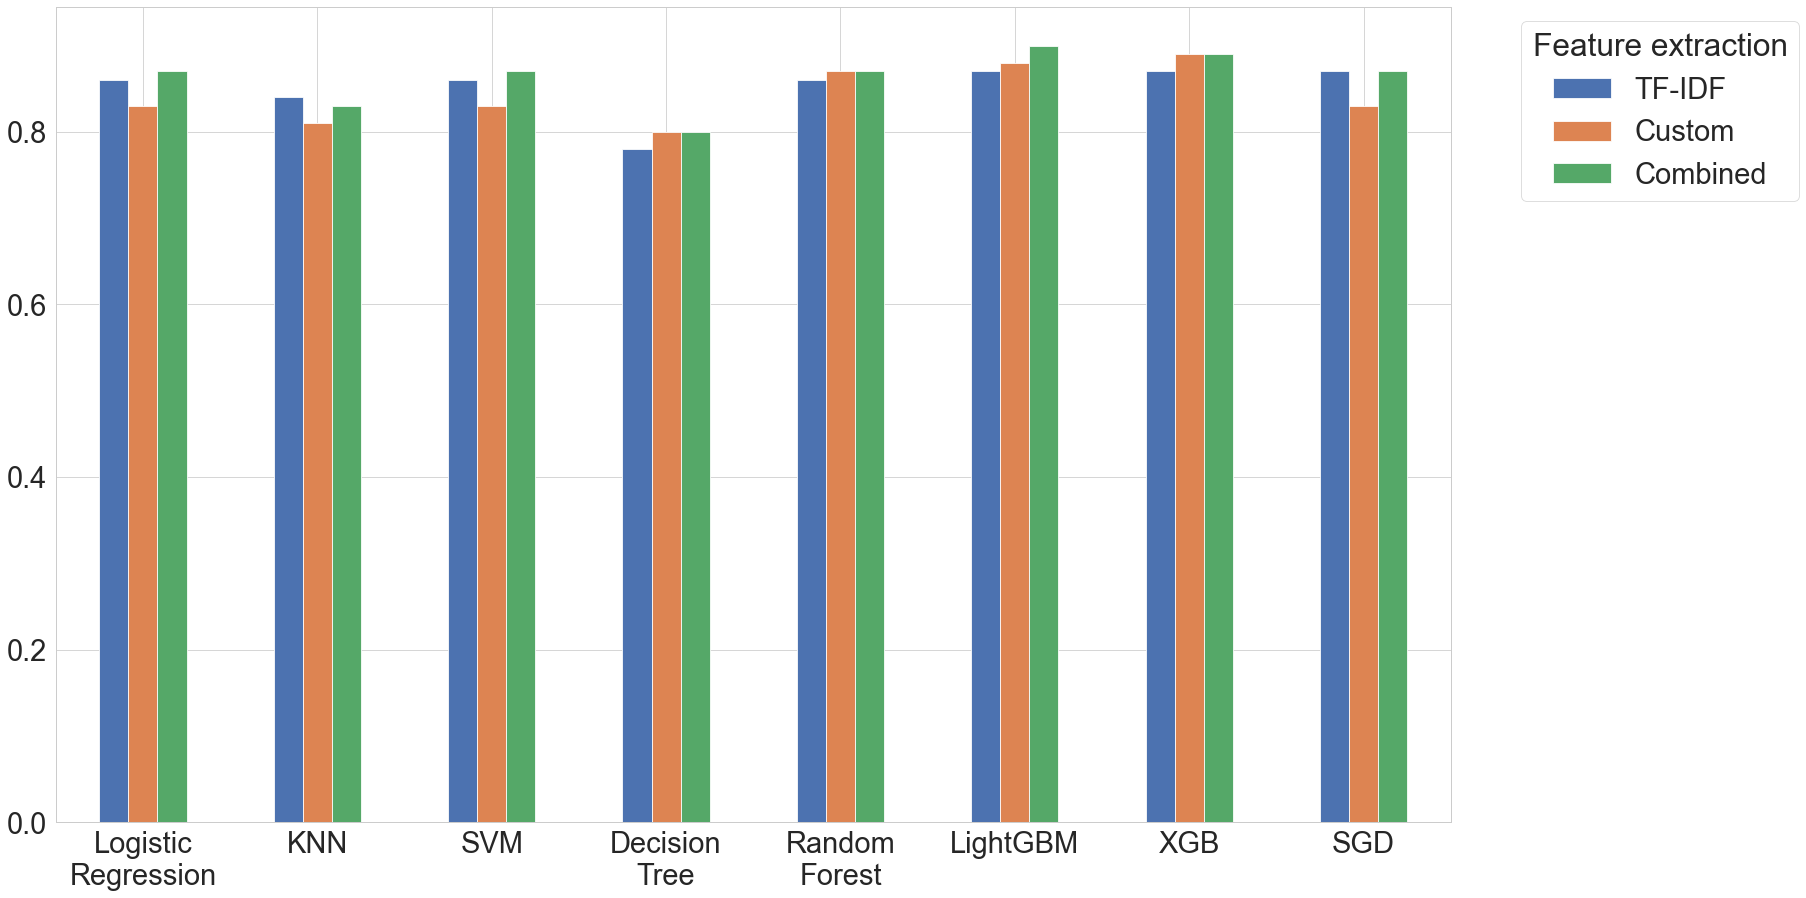

In [38]:
# accuracy plot
sns.set_theme(style="whitegrid")
labels = ['\n'.join(wrap(x, 12)) for x in  models] # custom label multi-line
sns.set_context('paper', font_scale=3.3)
acc_df.T.plot(kind='bar', figsize=(25, 15), rot=0)
plt.xticks(range(len(labels)), labels)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='Feature extraction')

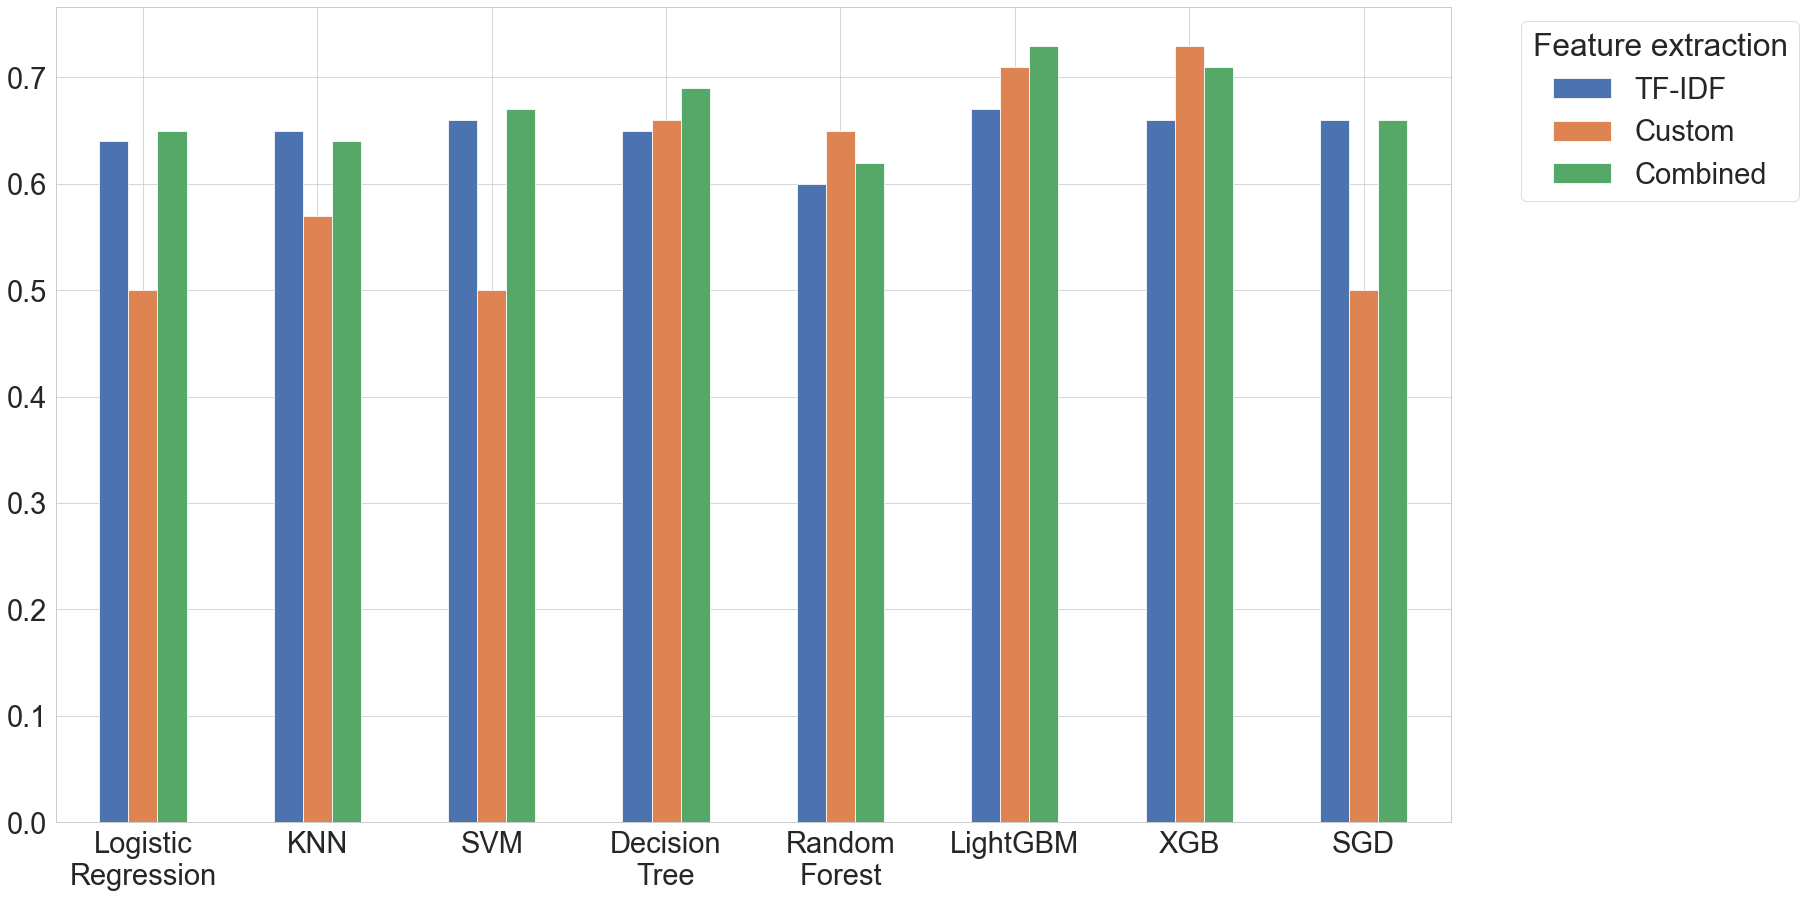

In [39]:
# auc plot
sns.set_context('paper', font_scale=3.3)
auc_df.T.plot(kind='bar', figsize=(25, 15), rot=0)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xticks(range(len(labels)), labels)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='Feature extraction')